$\Huge \rm Bayesian\ Cosmology$

Francisco Förster

In this notebook we will explore Bayesian inference methods to derive cosmological parameters


# MCMC Warm‑Up: Bayesian Linear Regression with Intrinsic Scatter

**Goal.** Learn and visualize the full Bayesian workflow with a simple, controlled problem before doing cosmology.

**What you'll do**
1. Generate/inspect synthetic data with known truth.
2. Specify priors and the likelihood (with intrinsic scatter).
3. Sample the posterior with:
   - (A) A simple Metropolis–Hastings (MH) sampler (pure NumPy; no dependencies).
   - (B) [`emcee`](https://emcee.readthedocs.io/) (if available).
4. Diagnose convergence (trace plots, acceptance rate, autocorrelation).
5. Summarize posteriors and make predictive checks.


In [1]:
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from scipy.integrate import quad

import emcee
import corner

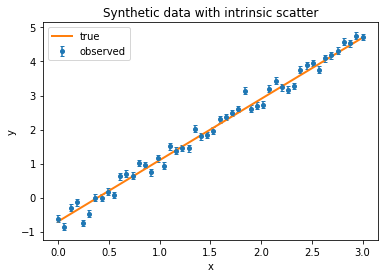

In [2]:
rng = np.random.default_rng(42)

# --- Simulate a line with intrinsic scatter ---
true_m = 1.8
true_b = -0.7
true_sigma_int = 0.25  # mag-like intrinsic scatter

N = 50
x = np.linspace(0, 3, N)
y_true = true_m*x + true_b
y = y_true + rng.normal(0, true_sigma_int, size=N)
yerr = np.full(N, 0.10)  # known measurement error

plt.figure(figsize=(6,4))
plt.errorbar(x, y, yerr=yerr, fmt='o', ms=4, capsize=2, label='observed')
plt.plot(x, y_true, lw=2, label='true')
plt.xlabel("x"); plt.ylabel("y")
plt.legend(); plt.title("Synthetic data with intrinsic scatter")
plt.show()

## Model, Priors, Likelihood

Model: 

$\Large y_i \sim \mathcal{N}(m x_i + b, \sigma_i^2 + \sigma_\mathrm{int}^2) $

Parameters: $ \theta = (m, b, \sigma_\mathrm{int}) $.

- Priors:  
  - $ m \sim \mathcal{U}(-5, 5) $  
  - $ b \sim \mathcal{U}(-5, 5) $  
  - $ \sigma_\mathrm{int} \sim \mathcal{U}(0, 2) $

Log-likelihood:

$ \Large
\ln \mathcal{L} = -\frac{1}{2}\sum_i \left[
\frac{(y_i - (m x_i + b))^2}{\sigma_i^2 + \sigma_\mathrm{int}^2}
+ \ln\big(2\pi(\sigma_i^2 + \sigma_\mathrm{int}^2)\big)
\right].
$

In [3]:
import numpy as np

def log_prior(theta):
    m, b, sigma_int = theta
    if -5 < m < 5 and -5 < b < 5 and 0 < sigma_int < 2.0:
        return 0.0  # log-uniform (flat) within bounds
    return -np.inf

def log_likelihood(theta, x, y, yerr):
    m, b, sigma_int = theta
    var = yerr**2 + sigma_int**2
    model = m*x + b
    return -0.5*np.sum((y - model)**2/var + np.log(2*np.pi*var))

def log_posterior(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

### (A) Pure NumPy Metropolis–Hastings

In [4]:
def mh_sampler(logpost, x, y, yerr, theta0, nsteps=20000, prop_scales=(0.05,0.05,0.02), rng=None):
    if rng is None:
        rng = np.random.default_rng()
    theta = np.array(theta0, dtype=float)
    chain = np.zeros((nsteps, len(theta)))
    logp = logpost(theta, x, y, yerr)
    acc = 0
    for i in range(nsteps):
        proposal = theta + rng.normal(0, prop_scales, size=len(theta))
        logp_prop = logpost(proposal, x, y, yerr)
        if np.log(rng.random()) < (logp_prop - logp):
            theta = proposal
            logp = logp_prop
            acc += 1
        chain[i] = theta
    return chain, acc/nsteps

theta0 = np.array([0.0, 0.0, 0.5])
chain, acc_rate = mh_sampler(log_posterior, x, y, yerr, theta0, nsteps=25000, prop_scales=(0.02,0.02,0.01), rng=rng)
burn = 5000
thin = 5
post = chain[burn::thin]

acc_rate

0.54576

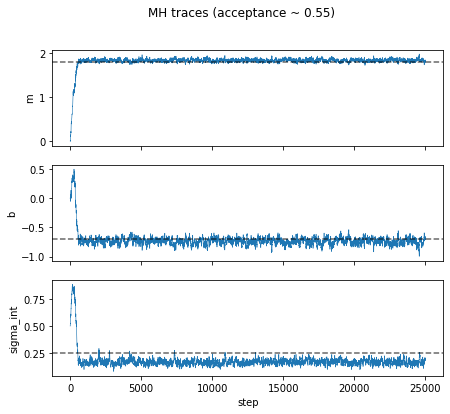

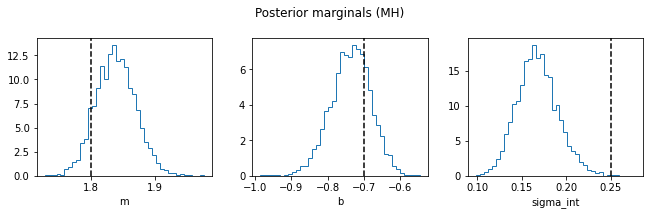

(array([ 1.83925773, -0.73760982,  0.16742889]),
 array([0.03151433, 0.05511805, 0.02362126]))

In [5]:
labels = ["m","b","sigma_int"]
fig, axes = plt.subplots(3, 1, figsize=(7,6), sharex=True)
for i, ax in enumerate(axes):
    ax.plot(chain[:,i], lw=0.6)
    ax.axhline([true_m, true_b, true_sigma_int][i], color='k', ls='--', alpha=0.6)
    ax.set_ylabel(labels[i])
axes[-1].set_xlabel("step")
fig.suptitle(f"MH traces (acceptance ~ {acc_rate:.2f})")
plt.show()

fig, axes = plt.subplots(1,3, figsize=(9,3))
for i, ax in enumerate(axes):
    ax.hist(post[:,i], bins=40, density=True, histtype='step')
    ax.axvline([true_m, true_b, true_sigma_int][i], color='k', ls='--')
    ax.set_xlabel(labels[i])
plt.suptitle("Posterior marginals (MH)")
plt.tight_layout()
plt.show()

np.mean(post, axis=0), np.std(post, axis=0)

### (B) emcee (optional)

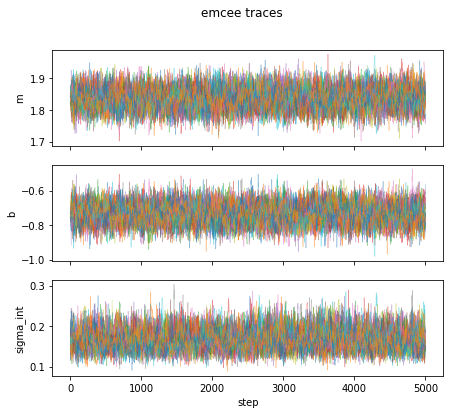

Posterior mean +/- std (emcee):
[ 1.83727999 -0.73224575  0.16759028] [0.03158821 0.05510955 0.02411407]


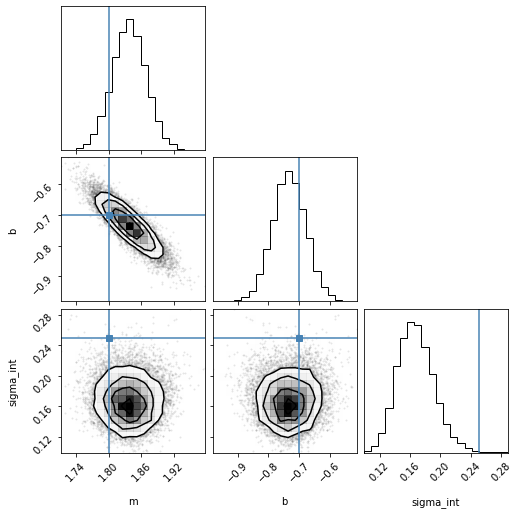

In [6]:
nwalkers = 32
ndim = 3
p0 = np.array([np.mean(post[:,0]), np.mean(post[:,1]), np.abs(np.mean(post[:,2]))])
p0s = p0 + 1e-2 * np.random.randn(nwalkers, ndim)

def lnprob(theta):
    return log_posterior(theta, x, y, yerr)

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)
_ = sampler.run_mcmc(p0s, 5000, progress=False)
flat = sampler.get_chain(discard=1000, thin=10, flat=True)

fig, axes = plt.subplots(3,1, figsize=(7,6), sharex=True)
for i in range(3):
    axes[i].plot(sampler.get_chain()[:,:,i], alpha=0.5, lw=0.5)
    axes[i].set_ylabel(labels[i])
axes[-1].set_xlabel("step")
plt.suptitle("emcee traces")
plt.show()

# Corner plot if available
corner.corner(flat, labels=labels, truths=[true_m, true_b, true_sigma_int])

print("Posterior mean +/- std (emcee):")
print(np.mean(flat, axis=0), np.std(flat, axis=0))


# Cosmology with Type Ia Supernovae: Flat ΛCDM via MCMC

In this notebook we fit a **flat ΛCDM** model to SN Ia **distance moduli** using MCMC.

- Parameters: $ \theta = (\Omega_m, \Delta M, \sigma_\mathrm{int}) $  
  - $ \Omega_m \in (0,1) $  
  - $ \Delta M $ is an additive offset (absorbs the \(H_0\)-\(M\) degeneracy when \(H_0\) is fixed)  
  - $ \sigma_\mathrm{int} $ is intrinsic scatter added in quadrature to the reported uncertainties
- We **fix** $ H_0 = 70~\mathrm{km\,s^{-1}\,Mpc^{-1}} $ for identifiability.
- Likelihood assumes independent Gaussian errors on $ \mu $. For a full analysis you would include the **systematic covariance matrix** (e.g., Pantheon+ provides this).

> **Data options**
> 1. Use the small demo CSV included here: `sn_demo.csv` (columns: `z, mu, sigma_mu`).  
> 2. Replace with **Pantheon+** (Scolnic et al. 2022) or **JLA** data files; see the README cell for details on expected columns.


https://github.com/PantheonPlusSH0ES/DataRelease/tree/main/Pantheon%2B_Data/4_DISTANCES_AND_COVAR


## Public SN Samples

- **Pantheon+** provides light curves and distance estimates; see Scolnic et al. (2022) data release. You can parse a table with columns similar to `zCMB` and `MU`, `MUERR`. 

For this teaching notebook, we keep the likelihood simple:

$ \Large
\ln \mathcal{L} = -\frac{1}{2}\sum_i \left[
\frac{(\mu_i - \mu_\mathrm{model}(z_i;\Omega_m) - \Delta M)^2}{\sigma_{\mu,i}^2 + \sigma_\mathrm{int}^2}
+ \ln\big(2\pi(\sigma_{\mu,i}^2 + \sigma_\mathrm{int}^2)\big)
\right].
$

SN-only data cannot determine $H_0$ without external calibration; $ \Delta M $ absorbs that degeneracy when we fix $H_0$.


We will use the following formulae valid for flat cosmology:

$\Large d_L(z) = (1+z)  D_C(z)$

$\Large D_C(z) = c \int_0^z \frac{dz'}{H(z')}$

$\Large H(z) = H_0 \sqrt{\Omega_m (1+z)^3 
+ \Omega_k (1+z)^2 + \Omega_\Lambda}.$

In [7]:
# Speed of light in km/s
c = 299792.458
H0 = 70.0  # km/s/Mpc (fixed)

def E_z(z, Om):
    # Flat ΛCDM => Omega_L = 1 - Om
    return np.sqrt(Om*(1+z)**3 + (1-Om))

def comoving_distance(z, Om):
    # D_C(z) = (c/H0) * \int_0^z dz'/E(z')
    val, _ = quad(lambda zp: 1.0/E_z(zp, Om), 0.0, z, epsabs=1e-7, epsrel=1e-7, limit=200)
    return (c/H0) * val  # Mpc

def luminosity_distance(z, Om):
    # D_L = (1+z) * D_C for flat
    return (1.0 + z) * np.vectorize(comoving_distance)(z, Om)

def mu_theory(z, Om, dM):
    # Distance modulus (D_L in Mpc): mu = 5 log10(D_L/Mpc) + 25 + dM
    DL = luminosity_distance(z, Om)
    return 5*np.log10(DL) + 25.0 + dM

def log_prior(theta):
    Om, dM, sigint = theta
    if 0.0 < Om < 1.0 and -1.0 < dM < 1.0 and 0.0 < sigint < 0.5:
        return 0.0  # flat within bounds
    return -np.inf

def log_likelihood(theta, z, mu, smu):
    Om, dM, sigint = theta
    var = smu**2 + sigint**2
    model = mu_theory(z, Om, dM)
    return -0.5*np.sum((mu - model)**2/var + np.log(2*np.pi*var))

def log_posterior(theta, z, mu, smu):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, z, mu, smu)

### Load data

/home/fforster/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<Axes: xlabel='zCMB', ylabel='MU_SH0ES'>

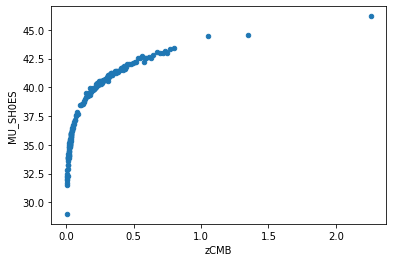

In [8]:
import pandas as pd
df = pd.read_csv("Pantheon+SH0ES.dat", sep="\s+")
nskip = 10 # use one every ten rows
df = df.iloc[::nskip]
df.plot.scatter(x="zCMB", y='MU_SH0ES')

,CID,IDSURVEY,zHD,zHDERR,zCMB,zCMBERR,zHEL,zHELERR,m_b_corr,m_b_corr_err_DIAG,...,PKMJDERR,NDOF,FITCHI2,FITPROB,m_b_corr_err_RAW,m_b_corr_err_VPEC,biasCor_m_b,biasCorErr_m_b,biasCor_m_b_COVSCALE,biasCor_m_b_COVADD
0,2011fe,51,0.00122,0.00084,0.00122,0.00002,0.00082,0.00002,9.74571,1.516210,...,0.1071,36,26.8859,8.644700e-01,0.0991,1.4960,0.0381,0.005,1.0,0.003
10,2001el,50,0.00333,0.00084,0.00357,0.00001,0.00379,0.00001,12.24810,0.590389,...,0.0329,97,493.8230,0.000000e+00,0.0584,0.5487,-0.0773,0.005,1.0,0.015
20,2012ht,5,0.00465,0.00084,0.00465,0.00002,0.00352,0.00002,12.78000,0.419535,...,0.0483,167,67.7490,1.000000e+00,0.0537,0.3932,0.0858,0.011,1.0,0.005
30,2018aoz,51,0.00548,0.00085,0.00701,0.00015,0.00587,0.00015,12.47520,0.500704,...,0.1147,44,43.8540,4.778400e-01,0.0617,0.3377,0.0730,0.008,1.0,0.005
40,2018gv,150,0.00602,0.00085,0.00596,0.00015,0.00510,0.00015,12.65720,0.349206,...,0.0963,28,115.0710,1.607440e-12,0.0694,0.3075,0.0384,0.004,1.0,0.003


N = 171 SNe


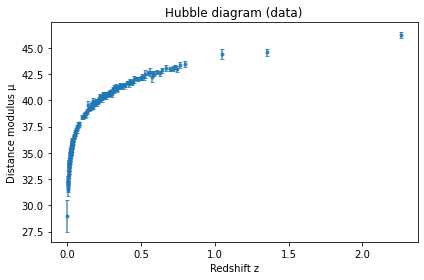

In [9]:
# Expected columns for the demo: z, mu, sigma_mu
# If using Pantheon+, adapt as: z = df['zCMB'], mu = df['MU'], sigma_mu = df['MUERR']
z = df['zCMB'].to_numpy()
mu = df['MU_SH0ES'].to_numpy()
smu = df['MU_SH0ES_ERR_DIAG'].to_numpy()

display(df.head())
print(f"N = {len(df)} SNe")

plt.figure(figsize=(6,4))
plt.errorbar(z, mu, yerr=smu, fmt='o', ms=3, capsize=2, alpha=0.8)
plt.xlabel("Redshift z"); plt.ylabel("Distance modulus μ")
plt.title("Hubble diagram (data)")
plt.tight_layout(); plt.show()

### Sample the posterior (MH, pure NumPy)

In [10]:
def mh_sampler(logpost, z, mu, smu, theta0, nsteps=5000, prop_scales=(0.02, 0.01, 0.005), rng=None):
    if rng is None:
        rng = np.random.default_rng(0)
    theta = np.array(theta0, dtype=float)
    chain = np.zeros((nsteps, len(theta)))
    logp = logpost(theta, z, mu, smu)
    acc = 0
    for i in range(nsteps):
        if np.mod(i, 500) == 0:
            print(i)
        proposal = theta + rng.normal(0, prop_scales, size=len(theta))
        logp_prop = logpost(proposal, z, mu, smu)
        if np.log(rng.random()) < (logp_prop - logp):
            theta = proposal
            logp = logp_prop
            acc += 1
        chain[i] = theta
    return chain, acc/nsteps

theta0 = [0.3, 0.0, 0.1]
chain, acc_rate = mh_sampler(log_posterior, z, mu, smu, theta0, nsteps=5000, prop_scales=(0.01,0.005,0.003))

burn, thin = 1000, 5
post = chain[burn::thin]
acc_rate


0
500
1000
1500
2000
2500
3000
3500
4000
4500


0.8132

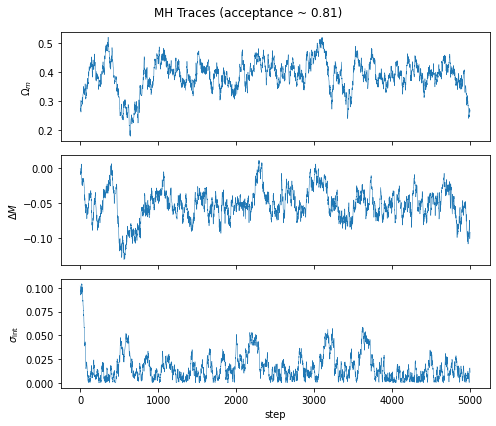

$\Omega_m$: 0.3963 ± 0.0427
$\Delta M$: -0.0499 ± 0.0191
$\sigma_{\rm int}$: 0.0157 ± 0.0125


In [11]:
labels = [r"$\Omega_m$", r"$\Delta M$", r"$\sigma_{\rm int}$"]

fig, axes = plt.subplots(3,1, figsize=(7,6), sharex=True)
for i, ax in enumerate(axes):
    ax.plot(chain[:,i], lw=0.5)
    ax.set_ylabel(labels[i])
axes[-1].set_xlabel("step")
fig.suptitle(f"MH Traces (acceptance ~ {acc_rate:.2f})")
plt.tight_layout(); plt.show()

means = np.mean(post, axis=0)
stds = np.std(post, axis=0)
for L, m, s in zip(labels, means, stds):
    print(f"{L}: {m:.4f} ± {s:.4f}")

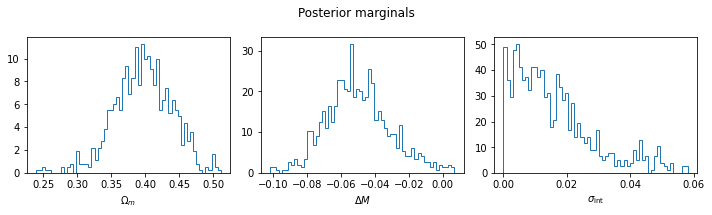

In [12]:
fig, axes = plt.subplots(1,3, figsize=(10,3))
for i, ax in enumerate(axes):
    ax.hist(post[:,i], bins=60, density=True, histtype='step')
    ax.set_xlabel(labels[i])
plt.suptitle("Posterior marginals")
plt.tight_layout(); plt.show()

### Overplot best-fit Hubble diagram

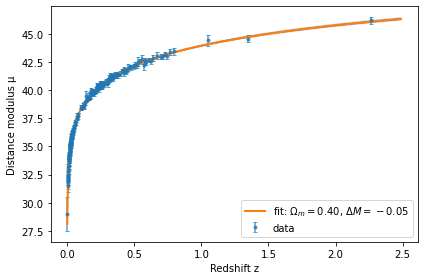

Derived q0 (flat ΛCDM): -0.406


In [13]:
plt.figure(figsize=(6,4))
plt.errorbar(z, mu, yerr=smu, fmt='o', ms=3, capsize=2, alpha=0.7, label="data")

zgrid = np.linspace(0.001, max(1.6, 1.1*z.max()), 400)

for i in range(100):
    Om_map, dM_map, s_map = post[int(np.random.random() * post.shape[0])]
    mu_fit = mu_theory(zgrid, Om_map, dM_map)
    plt.plot(zgrid, mu_fit, lw=0.5, c='gray', alpha=0.1)
    
Om_map, dM_map, s_map = means  # quick-and-dirty
mu_fit = mu_theory(zgrid, Om_map, dM_map)
plt.plot(zgrid, mu_fit, lw=2, label=fr"fit: $\Omega_m={Om_map:.2f}$, $\Delta M={dM_map:.2f}$")

plt.xlabel("Redshift z"); plt.ylabel("Distance modulus μ")
plt.legend(); plt.tight_layout(); plt.show()

# A simple derived parameter: deceleration parameter q0 = 1.5 Ωm - 1 (flat ΛCDM)
q0 = 1.5*Om_map - 1.0
print(f"Derived q0 (flat ΛCDM): {q0:.3f}")


### `emcee` sampler

If [`emcee`](https://emcee.readthedocs.io/) is installed, you can run a parallel-tempered sampler below.


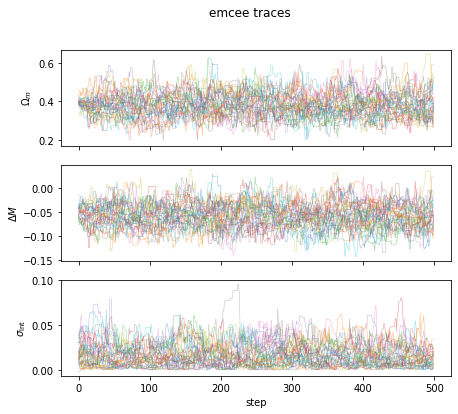

emcee posterior mean ± std:
[ 0.38329904 -0.05781099  0.01604438] [0.06398891 0.02556166 0.01228708]


In [15]:
nwalkers, ndim = 32, 3
p0 = means + 1e-2*np.random.randn(nwalkers, ndim)

def lnprob(theta):
    return log_posterior(theta, z, mu, smu)

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)
_ = sampler.run_mcmc(p0, 500, progress=False)
flat = sampler.get_chain(discard=100, thin=10, flat=True)

fig, axes = plt.subplots(3,1, figsize=(7,6), sharex=True)
for i in range(3):
    axes[i].plot(sampler.get_chain()[:,:,i], alpha=0.5, lw=0.5)
    axes[i].set_ylabel(labels[i])
axes[-1].set_xlabel("step")
plt.suptitle("emcee traces")
plt.show()

print("emcee posterior mean ± std:")
print(np.mean(flat, axis=0), np.std(flat, axis=0))

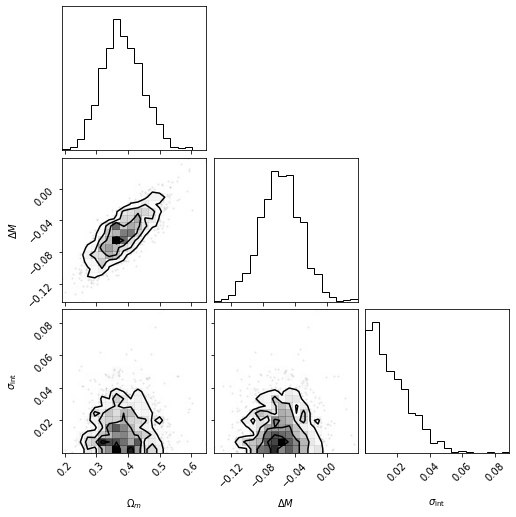

In [18]:
# Corner plot
corner.corner(flat, labels=labels);


# SN Ia Cosmology with **Full Covariance** (Pantheon) — ΛCDM and wCDM

This notebook fits **flat ΛCDM** and **flat wCDM** to Type Ia supernova distance moduli using a **full covariance** likelihood.

**Highlights**
- Stable log‑likelihood using **Cholesky** factorization of the total covariance.
- Parameters (ΛCDM): $ \theta = (\Omega_m, \Delta M, \sigma_\mathrm{int}) $.
- Parameters (wCDM): $ \theta = (\Omega_m, w, \Delta M, \sigma_\mathrm{int}) $.
- MCMC via a lightweight **Metropolis–Hastings** (pure NumPy) and `emcee`.



## 1)  Data Source

**Pantheon+** sample
  - Provide `MUERR` and a **systematics covariance** file (stat+sys = diag(MUERR²) + C_sys)

In [20]:
DATA_FILE = "Pantheon+SH0ES.dat"  
Z_COL, MU_COL, MUERR_COL = "zCMB", "MU_SH0ES", "MU_SH0ES_ERR_DIAG"  

# Covariance options for CUSTOM:
# COV_SYS_FILE (NxN) to be added to diag(MUERR^2).
COV_SYS_FILE  = "Pantheon+SH0ES_STAT+SYS.cov"

# MCMC settings
N_STEPS = 5000
BURN = 1000
THIN = 5

# Fixed H0 for identifiability
H0 = 70.0  # km/s/Mpc
c = 299792.458


## 2) Load/Build Data & Covariance


In [21]:
nskip = 10 # how many rows to skip (for speed)

def load_table(path, zcol, mucol, muerrcol=None):
    df = df = pd.read_csv(path, sep="\s+")
    df = df.iloc[::nskip]
    z  = df[zcol].to_numpy()
    mu = df[mucol].to_numpy()
    if muerrcol is not None and muerrcol in df.columns:
        smu = df[muerrcol].to_numpy()
    else:
        smu = None
    return z, mu, smu, df

def load_cov_from_txt(path, N_expected=None):
    # loads whitespace-separated matrix
    M = np.loadtxt(path)
    nrows = int(M[0])
    M = M[1:]
    M = np.reshape(M, (nrows, nrows))
    M = M[::nskip, ::nskip]
    if M.ndim != 2 or M.shape[0] != M.shape[1]:
        raise ValueError("Covariance must be a square 2D matrix.")
    if (N_expected is not None) and (M.shape[0] != N_expected):
        raise ValueError(f"Covariance size {M.shape} does not match N={N_expected}.")
    return M


z, mu, smu, df = load_table(DATA_FILE, Z_COL, MU_COL, MUERR_COL)
N = len(z)

C_sys = load_cov_from_txt(COV_SYS_FILE, N_expected=N)
if smu is None:
    raise ValueError("MUERR needed to build diag(MUERR^2) + C_sys")
C_full = np.diag(smu**2) + C_sys
print("Built covariance as diag(MUERR^2) + C_sys")

display(df.head())
print("Shapes — z:", z.shape, "mu:", mu.shape, "C:", C_full.shape)

Built covariance as diag(MUERR^2) + C_sys


,CID,IDSURVEY,zHD,zHDERR,zCMB,zCMBERR,zHEL,zHELERR,m_b_corr,m_b_corr_err_DIAG,...,PKMJDERR,NDOF,FITCHI2,FITPROB,m_b_corr_err_RAW,m_b_corr_err_VPEC,biasCor_m_b,biasCorErr_m_b,biasCor_m_b_COVSCALE,biasCor_m_b_COVADD
0,2011fe,51,0.00122,0.00084,0.00122,0.00002,0.00082,0.00002,9.74571,1.516210,...,0.1071,36,26.8859,8.644700e-01,0.0991,1.4960,0.0381,0.005,1.0,0.003
10,2001el,50,0.00333,0.00084,0.00357,0.00001,0.00379,0.00001,12.24810,0.590389,...,0.0329,97,493.8230,0.000000e+00,0.0584,0.5487,-0.0773,0.005,1.0,0.015
20,2012ht,5,0.00465,0.00084,0.00465,0.00002,0.00352,0.00002,12.78000,0.419535,...,0.0483,167,67.7490,1.000000e+00,0.0537,0.3932,0.0858,0.011,1.0,0.005
30,2018aoz,51,0.00548,0.00085,0.00701,0.00015,0.00587,0.00015,12.47520,0.500704,...,0.1147,44,43.8540,4.778400e-01,0.0617,0.3377,0.0730,0.008,1.0,0.005
40,2018gv,150,0.00602,0.00085,0.00596,0.00015,0.00510,0.00015,12.65720,0.349206,...,0.0963,28,115.0710,1.607440e-12,0.0694,0.3075,0.0384,0.004,1.0,0.003


Shapes — z: (171,) mu: (171,) C: (171, 171)


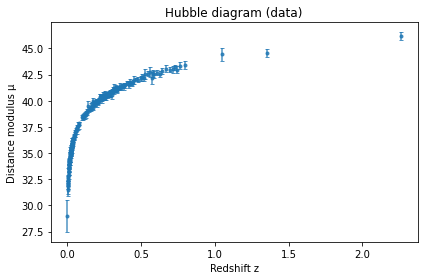

In [23]:
plt.figure(figsize=(6,4))
plt.errorbar(z, mu, yerr=(np.sqrt(np.diag(C_full)) if C_full is not None else None),
             fmt='o', ms=3, capsize=2, alpha=0.8)
plt.xlabel("Redshift z"); plt.ylabel("Distance modulus μ")
plt.title("Hubble diagram (data)")
plt.tight_layout(); plt.show()

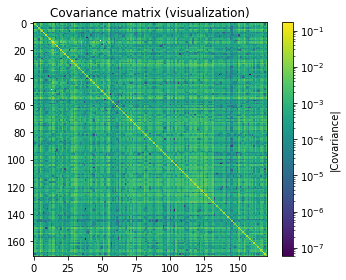

In [30]:
plt.figure(figsize=(5,4))
plt.imshow(np.abs(C_sys), origin="upper", interpolation="nearest", norm='log')
plt.colorbar(label="|Covariance|")
plt.title("Covariance matrix (visualization)")
plt.tight_layout(); plt.show()


## 3) Cosmology: Distances (ΛCDM / wCDM)


In [32]:
def E_z_LCDM(z, Om):
    return np.sqrt(Om*(1+z)**3 + (1-Om))

def E_z_wCDM(z, Om, w):
    return np.sqrt(Om*(1+z)**3 + (1-Om)*(1+z)**(3*(1+w)))

def comoving_distance(z, Om, w=None):
    if w is None:
        # ΛCDM
        f = lambda zp: 1.0/E_z_LCDM(zp, Om)
    else:
        f = lambda zp: 1.0/E_z_wCDM(zp, Om, w)
    if np.isscalar(z):
        val, _ = quad(f, 0.0, z, epsabs=1e-7, epsrel=1e-7, limit=200)
        return (c/H0) * val
    else:
        # basic trapz fallback
        if np.isscalar(z):
            return (c/H0) * _quad_fallback(lambda zp: 1.0/E_z_LCDM(zp, Om) if w is None else 1.0/E_z_wCDM(zp, Om, w), 0.0, z)
        else:
            xs = np.linspace(0, z.max(), 1200)
            ys = 1.0 / (E_z_LCDM(xs, Om) if w is None else E_z_wCDM(xs, Om, w))
            integ = np.trapz(ys, xs)
            return (c/H0) * np.interp(z, xs, np.cumsum(np.gradient(xs)*ys))  # rough fallback

def luminosity_distance(z, Om, w=None):
    Dc = comoving_distance(z, Om, w)
    return (1+z)*Dc

def mu_theory(z, Om, dM, w=None):
    DL = luminosity_distance(z, Om, w)
    return 5*np.log10(DL) + 25.0 + dM


## 4) Full‑Covariance Log‑Likelihood (with Intrinsic Scatter)

We assume the provided covariance captures stats+sys; we **add** an intrinsic scatter term $ \sigma_\mathrm{int}^2 $ to the diagonal.

$\Large
\ln \mathcal{L} = -\tfrac{1}{2}\left[
(\mathbf{r}^\top \mathbf{C}^{-1} \mathbf{r}) + \ln \det \mathbf{C} + N\ln(2\pi)\right],
\quad \mathbf{r} = \mu - \mu_{\rm model}.
$

We compute this stably via **Cholesky**:
- Solve 

$\mathbf{L}\mathbf{y}=\mathbf{r} $, then $ \mathbf{L}^\top\mathbf{x}=\mathbf{y} $ to get $ \mathbf{x} = \mathbf{C}^{-1}\mathbf{r} $.

- $\Large \ln \det \mathbf{C} = 2\sum \ln L_{ii} $.


In [33]:
def make_total_cov(C_base, sigint):
    # Add sigma_int^2 to the diagonal
    return C_base + np.eye(C_base.shape[0])*(sigint**2)

def loglike_fullcov(residual, C):
    # Cholesky-based log-likelihood
    try:
        L = np.linalg.cholesky(C)
    except np.linalg.LinAlgError:
        # Add small jitter to help numerical stability
        jitter = 1e-10 * np.eye(C.shape[0])
        L = np.linalg.cholesky(C + jitter)
    y = np.linalg.solve(L, residual)
    x = np.linalg.solve(L.T, y)
    quad_form = residual @ x # matrix operation in numpy
    logdet = 2.0 * np.sum(np.log(np.diag(L)))
    N = C.shape[0]
    return -0.5 * (quad_form + logdet + N * np.log(2 * np.pi))


## 5) Priors & Posteriors


In [34]:
def log_prior_lcdm(theta):
    Om, dM, sigint = theta
    if 0.0 < Om < 1.0 and -1.0 < dM < 1.0 and 0.0 < sigint < 0.5:
        return 0.0
    return -np.inf

def log_prior_wcdm(theta):
    Om, w, dM, sigint = theta
    if 0.0 < Om < 1.0 and -2.5 < w < -0.2 and -1.0 < dM < 1.0 and 0.0 < sigint < 0.5:
        return 0.0
    return -np.inf

def logpost_lcdm(theta, z, mu, C_base):
    lp = log_prior_lcdm(theta)
    if not np.isfinite(lp):
        return -np.inf
    Om, dM, sigint = theta
    model = mu_theory(z, Om, dM, w=None)
    C = make_total_cov(C_base, sigint)
    resid = mu - model
    return lp + loglike_fullcov(resid, C)

def logpost_wcdm(theta, z, mu, C_base):
    lp = log_prior_wcdm(theta)
    if not np.isfinite(lp):
        return -np.inf
    Om, w, dM, sigint = theta
    model = mu_theory(z, Om, dM, w=w)
    C = make_total_cov(C_base, sigint)
    resid = mu - model
    return lp + loglike_fullcov(resid, C)

## 6) MCMC Sampler (MH)


In [36]:
def mh_sampler(logpost, theta0, nsteps=20000, prop_scales=None, rng=None):
    theta0 = np.array(theta0, dtype=float)
    ndim = len(theta0)
    if prop_scales is None:
        prop_scales = np.full(ndim, 0.01)
    if rng is None:
        rng = np.random.default_rng(0)
    chain = np.zeros((nsteps, ndim))
    theta = theta0.copy()
    logp = logpost(theta)
    acc = 0
    for i in range(nsteps):
        if np.mod(i, 500) == 0:
            print(i)
        prop = theta + rng.normal(0, prop_scales, size=ndim)
        logp_prop = logpost(prop)
        if np.log(rng.random()) < (logp_prop - logp):
            theta = prop
            logp = logp_prop
            acc += 1
        chain[i] = theta
    return chain, acc/nsteps


## 7) Fit ΛCDM


0
500
1000
1500
2000
2500
3000
3500
4000
4500
ΛCDM acceptance rate: 0.8348
ΛCDM posterior mean ± std: [ 0.22601948 -0.17811634  0.01821966] [0.04264252 0.02199549 0.01433073]


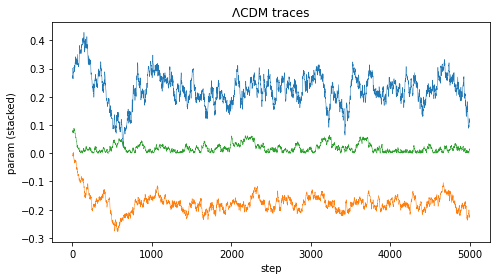

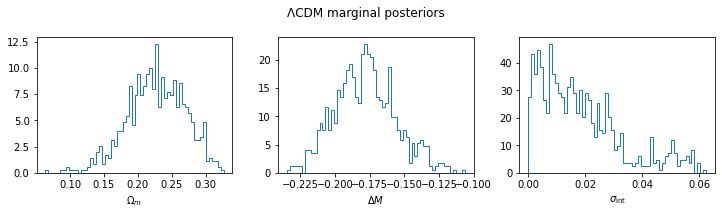

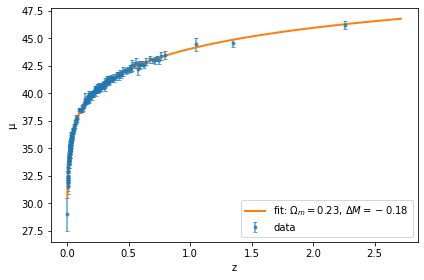

Derived deceleration parameter (flat ΛCDM): q0 = -0.661


In [37]:
C_base = C_full.copy()  # base covariance (before adding sigma_int^2)

# Initial guess & proposal scales
theta0_lcdm = np.array([0.3, 0.0, 0.08])   # (Om, dM, sigint)
prop_lcdm   = np.array([0.01, 0.005, 0.003])

logpost = lambda th: logpost_lcdm(th, z, mu, C_base)

N_STEPS = 5000
BURN = 1000
THIN = 5
chain_l, acc_l = mh_sampler(logpost, theta0_lcdm, nsteps=N_STEPS, prop_scales=prop_lcdm)
post_l = chain_l[BURN::THIN]
means_l = post_l.mean(axis=0)
stds_l  = post_l.std(axis=0)

print("ΛCDM acceptance rate:", acc_l)
print("ΛCDM posterior mean ± std:", means_l, stds_l)

labels_l = [r"$\Omega_m$", r"$\Delta M$", r"$\sigma_{\rm int}$"]

plt.figure(figsize=(7,4))
for i in range(3):
    plt.plot(chain_l[:,i], lw=0.5)
plt.xlabel("step"); plt.ylabel("param (stacked)")
plt.title("ΛCDM traces")
plt.tight_layout(); plt.show()

fig, axes = plt.subplots(1,3, figsize=(10,3))
for i, ax in enumerate(axes):
    ax.hist(post_l[:,i], bins=60, density=True, histtype='step')
    ax.set_xlabel(labels_l[i])
plt.suptitle("ΛCDM marginal posteriors")
plt.tight_layout(); plt.show()

# Hubble diagram with best-fit
zgrid = np.linspace(max(0.001, z.min()*0.8), 1.2*max(z.max(), 1.2), 500)
mu_fit = mu_theory(zgrid, means_l[0], means_l[1], w=None)
plt.figure(figsize=(6,4))
plt.errorbar(z, mu, yerr=np.sqrt(np.diag(C_base)), fmt='o', ms=3, capsize=2, alpha=0.7, label="data")
plt.plot(zgrid, mu_fit, lw=2, label=fr"fit: $\Omega_m={means_l[0]:.2f}$, $\Delta M={means_l[1]:.2f}$")
plt.xlabel("z"); plt.ylabel("μ"); plt.legend(); plt.tight_layout(); plt.show()

q0 = 1.5*means_l[0] - 1.0
print(f"Derived deceleration parameter (flat ΛCDM): q0 = {q0:.3f}")


## 8) Fit wCDM (constant \(w\))


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
wCDM acceptance rate: 0.7903
wCDM posterior mean ± std: [ 0.42044115 -2.1681764  -0.23937934  0.01879375] [0.04420261 0.25567394 0.02902433 0.01629079]


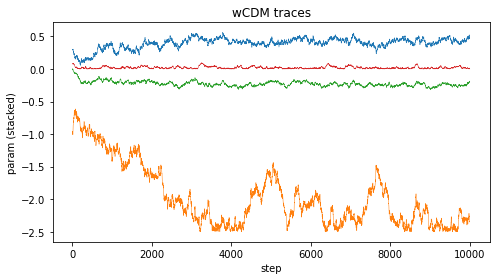

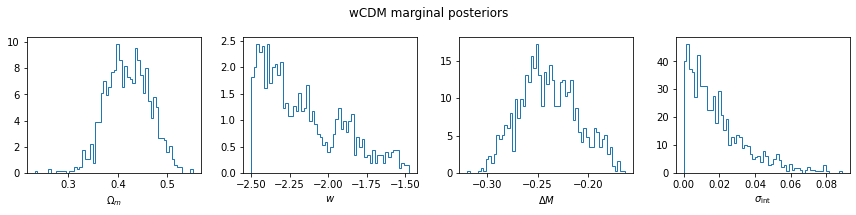

In [39]:
theta0_wcdm = np.array([0.3, -1.0, 0.0, 0.08])  # (Om, w, dM, sigint)
prop_wcdm   = np.array([0.01, 0.02, 0.005, 0.003])

logpost_w = lambda th: logpost_wcdm(th, z, mu, C_base)

N_STEPS = 10000
BURN = 4000
chain_w, acc_w = mh_sampler(logpost_w, theta0_wcdm, nsteps=N_STEPS, prop_scales=prop_wcdm)
post_w = chain_w[BURN::THIN]
means_w = post_w.mean(axis=0)
stds_w  = post_w.std(axis=0)

print("wCDM acceptance rate:", acc_w)
print("wCDM posterior mean ± std:", means_w, stds_w)

labels_w = [r"$\Omega_m$", r"$w$", r"$\Delta M$", r"$\sigma_{\rm int}$"]

plt.figure(figsize=(7,4))
for i in range(4):
    plt.plot(chain_w[:,i], lw=0.5)
plt.xlabel("step"); plt.ylabel("param (stacked)")
plt.title("wCDM traces")
plt.tight_layout(); plt.show()

fig, axes = plt.subplots(1,4, figsize=(12,3))
for i, ax in enumerate(axes):
    ax.hist(post_w[:,i], bins=60, density=True, histtype='step')
    ax.set_xlabel(labels_w[i])
plt.suptitle("wCDM marginal posteriors")
plt.tight_layout(); plt.show()

This doesn't make sense, probable bug :(


## 9)`emcee` for either model


In [ ]:
import emcee

def run_emcee(init, logpost_fn, nwalkers=32, nsteps=8000, burn=2000, thin=10):
    ndim = init.size
    p0 = init + 1e-2*np.random.randn(nwalkers, ndim)
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lambda p: logpost_fn(p))
    _ = sampler.run_mcmc(p0, nsteps, progress=False)
    flat = sampler.get_chain(discard=burn, thin=thin, flat=True)
    return flat, sampler

flat_l, sampler_l = run_emcee(means_l, lambda p: logpost_lcdm(p, z, mu, C_base))
print("emcee ΛCDM mean ± std:", flat_l.mean(axis=0), flat_l.std(axis=0))

fig, axes = plt.subplots(3,1, figsize=(7,6), sharex=True)
for i in range(3):
    axes[i].plot(sampler_l.get_chain()[:,:,i], alpha=0.5, lw=0.5)
    axes[i].set_ylabel(labels[i])
axes[-1].set_xlabel("step")
plt.suptitle("emcee traces")
plt.show()

In [ ]:
corner.corner(flat_l, labels=labels_l);

In [ ]:
flat_w, sampler_w = run_emcee(means_w, lambda p: logpost_wcdm(p, z, mu, C_base))
print("emcee wCDM mean ± std:", flat_w.mean(axis=0), flat_w.std(axis=0))

fig, axes = plt.subplots(3,1, figsize=(7,6), sharex=True)
for i in range(3):
    axes[i].plot(sampler_w.get_chain()[:,:,i], alpha=0.5, lw=0.5)
    axes[i].set_ylabel(labels[i])
axes[-1].set_xlabel("step")
plt.suptitle("emcee traces")
plt.show()

In [ ]:
corner.corner(flat_w, labels=labels_w);